# Star Trek Script Generator

## Just want to make scripts?

* Run everything in the setup section
* Then go straight to generate scripts section, skipping the rest

## Want to train up the model?

* Run the whole notebook

## Thanks and Attributions

Based on [script_generation.ipynb](https://github.com/cdpierse/script_buddy_v2/blob/master/script_buddy/script_generation.ipynb)

## Setup


In [1]:
!pip -q install transformers

     |████████████████████████████████| 675kB 8.1MB/s 
     |████████████████████████████████| 3.8MB 27.5MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 
     |████████████████████████████████| 1.2MB 50.9MB/s 


In [0]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelWithLMHead
import numpy as np
import os
import random
from datetime import datetime
from IPython.display import clear_output
from time import sleep
from zipfile import ZipFile
import subprocess
# from utils import *

In [0]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

## Load Model

In [4]:
MODEL_NAME = 'alexcg1/trekbot'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Loaded Tokenizer from {MODEL_NAME}")
model = AutoModelWithLMHead.from_pretrained(MODEL_NAME)
print(f"Loaded Model from {MODEL_NAME}")


Loaded Tokenizer from alexcg1/trekbot



Loaded Model from alexcg1/trekbot


In [0]:
model = model.to(device)

## Train Model

If you just want scripts, skip straight to the "Generating Samples" section

### Training Settings

In [0]:
# How many episodes to train on? If 0, assume all episodes
EP_COUNT = 6000

# How many times to cycle through all episodes in training?
EPOCHS = 1

# How many batches to run together?
BATCH_SIZE = 1

# Sample length for samples generated from model
SAMPLE_LENGTH = 500
SAMPLE_COUNT = 6

# What text should we train on? Default is Star Trek episodes
TRAINING_FILE_PATH = os.path.join("trekbot", "data", "film_text.txt")

In [7]:
# Clone repo with dataset

if not os.path.exists('trekbot'):
  os.mkdir('trekbot')
  !git clone https://github.com/alexcg1/trekbot_script-writer.git trekbot
else:
  %cd trekbot
  !git pull
  %cd ..

Cloning into 'trekbot'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 47 (delta 13), reused 41 (delta 7), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [0]:
# Copy out includes
!cp trekbot/*.py .

In [0]:
FILENAME_SUFFIX = str(datetime.now())[:10]

# Filename for output scripts
SCRIPT_DIR = f"training-scripts/"
SCRIPT_FILENAME = f"scripts-{FILENAME_SUFFIX}.txt"

# Directory to save model
OUTPUT_MODEL_DIR = f"models/trekbot"
OUTPUT_MODEL_FILENAME = f"model.txt"

# This variable already used in code later
output_dir = OUTPUT_MODEL_DIR

In [10]:
from utils import Setup
dirs = ['models', SCRIPT_DIR, 'samples']

Setup.dir_setup(dirs) # Setup directory structure

Created models
Created training-scripts/
Created samples


### Load Dataset

It's already pickled for fast loading

In [11]:
import pickle
import language_modelling

pickle_path = os.path.join("trekbot", "data", "gpt2_trekbot.txt")
dataset = pickle.load(open(pickle_path, "rb"))
print(f"Dataset has {len(dataset)} scripts total")

Dataset has 13051 scripts total


### Set episode count

For testing the whole pipeline works, I'm just running it with a few episodes to start with

In [0]:
if EP_COUNT != 0:
    dataset = dataset[:EP_COUNT]

In [13]:
script_loader = DataLoader(dataset,batch_size=1,shuffle=True)
if EP_COUNT != 0:
    print(f"Loaded {EP_COUNT} scripts from dataset")
else:
    print("Loaded all scripts from dataset")

Loaded 6000 scripts from dataset


In [0]:
LEARNING_RATE = 0.00006 # Faster uses more GPU?
WARMUP_STEPS = 10000

In [0]:
model = model.to(device)
model.train() # Start training mode
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=-1)
script_count = 0
sum_loss = 0.0
batch_count = 0

In [0]:
total = len(dataset) # number of items in dataset

In [17]:
SAMPLE_INTERVAL = int(total/SAMPLE_COUNT)
# total_sample_count = floor(total/SAMPLE_INTERVAL)
print(f"Total samples: {SAMPLE_COUNT}")

Total samples: 6


In [18]:
start_time = datetime.now().strftime("%H:%M:%S")
print(f"Start: {start_time}")

Start: 00:38:28


In [19]:
from utils import Diag
# Setup diagnostics
losses = []
loss_log = "loss_rate.csv"

Diag.setup(loss_log)

Creating new log at loss_rate.csv


In [0]:
from ipywidgets import IntProgress
from IPython.display import display
progress_bar = IntProgress(min=0, max=total) # instantiate the bar

In [25]:
display(progress_bar)
for epoch in range(EPOCHS):
    print(f"EPOCH {epoch} started" + '=' * 30)
    for idx,script in enumerate(script_loader):
                
        outputs = model(script.to(device), labels=script.to(device))
        
        loss, logits = outputs[:2]
        timestamp = datetime.now().strftime("%H:%M:%S")
        
        loss.backward()

        sum_loss = sum_loss + loss.detach().data
                       
        script_count = script_count + 1
        if script_count == BATCH_SIZE:
            script_count = 0    
            batch_count += 1
            optimizer.step()
            scheduler.step() 
            optimizer.zero_grad()
            model.zero_grad()
        
        if batch_count == SAMPLE_INTERVAL:
            append_string = f"\t| Appending script to {SCRIPT_FILENAME}..."
        else:
            append_string = ''
        
        # Update progress bar
        progress_bar.value +=1

        # Update output display
        clear_output(wait=True) # Clear and update display, otherwise endless scroll
        percent = round((idx/total)*100, 5)
        rounded_loss = round(float(loss.detach().data), 3)
        rounded_sum_loss = round(float(sum_loss), 2)
        losses.append(rounded_loss)
        print(f"{timestamp}: Processing {idx}/{total} \t {percent}% \tLoss: {rounded_loss} {append_string}")
        data = [timestamp, LEARNING_RATE, rounded_loss]
        Diag.write_row(data, loss_log)
        if batch_count == SAMPLE_INTERVAL:
            print("Saving script")
            model.eval()
            # losses.append(sum_loss)
            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = SAMPLE_LENGTH,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )

            for i, sample_output in enumerate(sample_outputs):
                SCRIPT_PATH = os.path.join(SCRIPT_DIR, SCRIPT_FILENAME)
                with open(SCRIPT_PATH, "a") as file:
                    file.write("\n\n")
                    file.write("*" * 80)
                    file.write("\n\n")
                    file.write(tokenizer.decode(sample_output, skip_special_tokens=True))
                    print(f"Script appended to {SCRIPT_FILENAME}")
            
            batch_count = 0
            sum_loss = 0.0
            model.train()

01:44:07: Processing 5999/6000 	 99.983% 	Loss: 2.485 | Sum loss: 1697.46 


In [26]:
end_time = datetime.now().strftime("%H:%M:%S")
print(f"Start: {start_time}")
print(f"End: {end_time}")

Start: 00:38:28
End: 01:44:30


### Analyze Training

You can skip this if you want. It just gives you an idea if the training is improving the loss rate or not. If things are going well, you should see a downward sloping graph

6000
6000


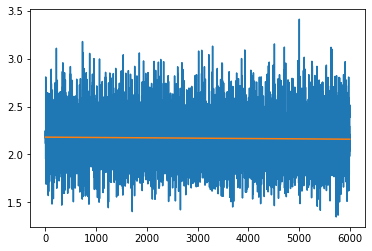

In [34]:
y = np.array(losses[0:6000])
x = np.array(range(total))
print(len(y))
print(len(x))
m, b = np.polyfit(x, y, 1)

from matplotlib import pyplot as plt
plt.plot(x, y)
plt.plot(x, m*x + b)
plt.show()

### Save Trained Model

In [35]:
# os.chdir("/kaggle/working")
os.mkdir(OUTPUT_MODEL_DIR)

from transformers import WEIGHTS_NAME, CONFIG_NAME
output_model_file = os.path.join(OUTPUT_MODEL_DIR, WEIGHTS_NAME)
output_config_file = os.path.join(OUTPUT_MODEL_DIR, CONFIG_NAME)

torch.save(model.state_dict(), output_model_file)
print(f"Saved {output_model_file} to {OUTPUT_MODEL_DIR}")
model.config.to_json_file(output_config_file)
print(f"Saved {output_config_file} to {OUTPUT_MODEL_DIR}")
tokenizer.save_vocabulary(OUTPUT_MODEL_DIR)
print(f"Saved vocabulary to {OUTPUT_MODEL_DIR}")

Saved models/trekbot/pytorch_model.bin to models/trekbot
Saved models/trekbot/config.json to models/trekbot
Saved vocabulary to models/trekbot


In [36]:
# Saved model will be used to generate samples
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
print(f"Loaded model and tokenizer from {output_dir}")

Loaded model and tokenizer from models/trekbot


## Generate Samples

In [0]:
def generate_sample(length):
  model.eval() # Turn on evaluation mode instead of training
  output = model.generate(
      bos_token_id=random.randint(1,30000),
      do_sample=True,   
      top_k=50, 
      max_length = length,
      top_p=0.95, 
      num_return_sequences=1
      )

  content = tokenizer.decode(output[0], skip_special_tokens=True)

  return content

In [0]:
sample_scripts = []

In [49]:
SAMPLE_COUNT = 1
for i in range(SAMPLE_COUNT):
  print(f"Generating script {i+1} of {SAMPLE_COUNT}")
  sample_script = generate_sample(SAMPLE_LENGTH)
  sample_scripts.append(sample_script)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


Generating script 1 of 1


In [51]:
for script in sample_scripts:
  print(script)
  print(f"\n\n")

dogs. We knew you wouldn't stay. 
(Raj sits on the grass, looking into the abyss.)

 [Holding cell]

(Raj is in a cell, and Dax is at a table.) 
DAX: What are you doing? 
ODO: I'm trying to make this go away. I have to help them. 
DUKAT: You can't just turn your back on them. 
ODO: I don't know. 
RISSA: I'm not sure this is the best time for you to turn your back on the
Dominion. I mean, I understand you've been in Starfleet for two years. 
ODO: And I understand the Federation can't allow our Federation to
destroy itself. 
DUKAT: But the sooner you accept these facts, the sooner we can reach
a solution, which is exactly what we're trying to do. I've known
Federation officials for twenty years. I can't just give up a job I
am passionate about. 
ODO: What's the plan? 
DUKAT: I'm sorry, I just can't seem to find a better time. 
ODO: The more I hear about Cardassian security procedures, the more
concerns I have. 
DUKAT: I'm sorry. I know they're trying to kill me. But they're
not here to g

In [52]:
# Save sample scripts
for i, script in enumerate(sample_scripts):
    filename = f'script_{i+1:03}.txt'
    file_path = f'samples/{filename}'
    with open(file_path, 'w') as file:
        file.write(script)
    print(f"{filename} written")

script_001.txt written
script_002.txt written
script_003.txt written


In [53]:
# Zip samples
os.chdir('samples')
with ZipFile('samples.zip', 'w') as zipObj:
    for filename in os.listdir():
        if not filename.endswith(".zip"):
            zipObj.write(filename)

print("samples.zip created")

samples.zip created
